In [206]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


import matplotlib.pyplot as plt
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
import glob
import cv2

In [207]:
"""physical_devices=tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0],False)"""

'physical_devices=tf.config.list_physical_devices("GPU")\ntf.config.experimental.set_memory_growth(physical_devices[0],False)'

# Telechargement données

In [208]:
# Téléchargement des fichiers de sous-titres
# Download caption annotation files
annotation_folder = 'C:/Users/utilisateur/Projet_CNN/RNN_1/annotations'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
    annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
    annotation_file = os.path.dirname(annotation_zip)+'C:/Users/utilisateur/Projet_CNN/RNN_1/annotations/captions_train2014.json'
    os.remove(annotation_zip)

# Download image files
image_folder = 'C:/Users/utilisateur/Projet_CNN/RNN_1/train2014'
if not os.path.exists(os.path.abspath('.') + image_folder):
    image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
    PATH = os.path.dirname(image_zip) + image_folder
    os.remove(image_zip)
else:
    PATH = os.path.abspath('.') + image_folder

 42557440/252872794 [====>.........................] - ETA: 56s

KeyboardInterrupt: 

In [210]:
annotation_file = 'C:/Users/utilisateur/Projet_CNN/RNN_1/annotations/captions_train2014.json'


# Pour limiter la taille de l'ensemble d'apprentissage (Optionnel)

In [211]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)
#PATH=os.path.abspath("C:/Users/utilisateur/Projet_CNN/RNN_1/train2014")

In [212]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    caption = f"<start> {val['caption']} <end>"
    image_path = PATH + '/COCO_train2014_'+'%012d.jpg' % (val['image_id'])
    image_path_to_caption[image_path].append(caption)

In [213]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [216]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
    
    caption_list = image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    img_name_vector.extend([image_path] * len(caption_list))

<start> a person standing on a kitchen counter painting  <end>


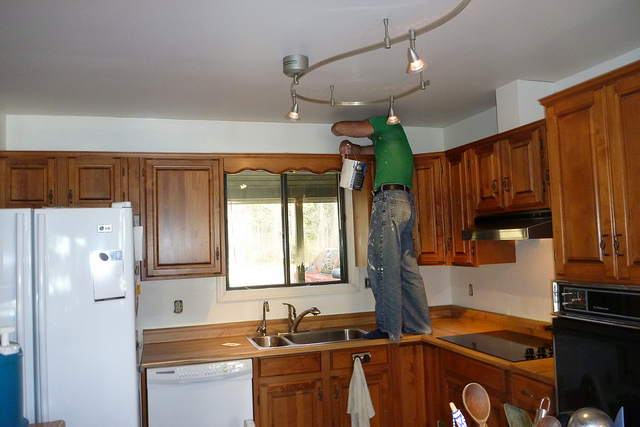

In [217]:
print(train_captions[0])
Image.open(img_name_vector[0])

# Prétraiter les images avec InceptionV3

In [218]:
#image_path="C:/Users/utilisateur/train2014"

In [219]:
def load_image(image_path):
    
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img,channels=3)
    img = tf.image.resize(img,(299,299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    
    return img, image_path
    

# Initialisez InceptionV3 

In [220]:
image_model  = tf.keras.applications.InceptionV3(include_top = False,
                                                 weights = "imagenet")
new_input    = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input,hidden_layer)

# Mise en cache des fonctionnalités extraites d'inceptionV3

In [221]:
from tqdm import tqdm

In [222]:
#Récupération d'images uniques
encode_train = sorted(set(img_name_vector))

#Modifier le batch_size en fonction de notre système (plus ou moins perfo)

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)
np_images = {}

for img,path in tqdm(image_dataset):
    
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                             (batch_features.shape[0],
                             -1,
                              batch_features.shape[3])
                             )
    
    for bf,p in zip(batch_features,path):
        
        path_of_feature = p.numpy().decode("utf-8")
        np_images[path_of_feature]=bf.numpy()

100%|██████████| 375/375 [13:14<00:00,  2.12s/it]


# Prétraiter et tokeniser les sous-titres

In [223]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

def standardize(inputs):
    
    inputs = tf.strings.lower(inputs)
    
    return tf.strings.regex_replace(inputs,
                                    r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

#Mots max par captation
max_lenght = 50

vocabulary_size = 5000
tokenizer = TextVectorization(max_tokens = vocabulary_size,
                             standardize = standardize,
                             output_sequence_length = max_lenght)

tokenizer.adapt(caption_dataset)

vocabulary_size = 5000



#assign token for pad
#tokenizer.word_index["<pad>"] = 0
#tokenizer.index_word[0] = "<pad>"

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs,
                                                padding = "post"
                                               )


# Create mappings for words to indices and indicies to words.

word_to_index = tf.keras.layers.experimental.preprocessing.StringLookup(
    mask_token = "",
    vocabulary = None)

index_to_word = tf.keras.layers.experimental.preprocessing.StringLookup(
    mask_token = "",
   vocabulary = None,
    invert = True)

# Séparation data train et validation

In [224]:
img_to_cap_vector=collections.defaultdict(list)

for img,cap in zip(img_name_vector,cap_vector):
    img_to_cap_vector[img].append(cap)
    
#Création des jeux d'entrainement et de validation, en utilisant une séparation 80-20 aléatoirement
img_keys=list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index=int(len(img_keys)*0.8)
img_name_train_keys,img_name_val_keys=img_keys[:slice_index],img_keys[slice_index:]

img_name_train=[]
cap_train=[]

for imgt in tqdm(img_name_train_keys):
    capt_len=len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt]*capt_len)
    cap_train.extend(img_to_cap_vector[imgt])
    
img_name_val=[]
cap_val=[]

for imgv in tqdm(img_name_val_keys):
    capv_len=len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv]*capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

100%|██████████| 1200/1200 [00:00<00:00, 401112.91it/s]


In [225]:
len(img_name_train), len(cap_train),len(img_name_val),len(cap_val)

(24014, 24014, 6003, 6003)

# Création d'un jeu de données tf.data pour l'entrainement

In [226]:
BATCH_SIZE=64
BUFFER_SIZE=1000
embedding_dim=256
units=512
vocab_size=5000
num_steps=len(img_name_train)//BATCH_SIZE
#la forme du vecteur extrait d'InceptionV3 est (64,2048)
features_shape=2048
attention_features_shape=64

In [227]:
#Chargement des fichiers numpy
def map_func(img_name,cap):
    
    img_tensor = np_images[img_name.decode("utf-8")].astype(np.float32)
    
    return img_tensor,cap

In [228]:
dataset=tf.data.Dataset.from_tensor_slices((img_name_train,cap_train))

#utilisation de map pour charger les fichiers numpy en parallèles

dataset = dataset.map(lambda item1, item2: tf.numpy_function(
                    map_func,[item1,item2],[tf.float32, tf.int32]),
                   num_parallel_calls=tf.data.AUTOTUNE)

#Mélange et batch

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Définition et construction du modèle

### Architecure badhanau:
    -Nous extrayons les caractéristiques de la couche convolutive basse d'InceptionV3, donnant vecteur (8,8,2048)
    -Nous écrasons sous la forme (64,2048)
    -Ce vecteur passe ensuite dans l'encoder CNN (une couche complétement connectée)
    -Le RNN (ici GRU) s'appui sur l'image pour prédire le prochain mot

In [229]:
#Définition encoder

class CNN_Encoder(tf.keras.Model):
    
    def __init__(self,embeddinng_dim):
        
        super(CNN_Encoder,self).__init__()
        
        #forme après fc==(batch_size,64,embedding_dim)
        self.fc=tf.keras.layers.Dense(embedding_dim)
        
    def call(self,x):
        
        x=self.fc(x)
        x=tf.nn.relu(x)
        
        return x
        

# Definition de l'algorithme d'attention

In [230]:
class BahdanauAttention(tf.keras.Model):
    
    def __init__(self,units):
        
        super(BahdanauAttention,self).__init__()
        
        self.W1=tf.keras.layers.Dense(units)
        self.W2=tf.keras.layers.Dense(units)
        self.V=tf.keras.layers.Dense(1)
        
    def call(self,features,hidden):
        
        hidden_with_time_axis=tf.expand_dims(hidden,1)
        attention_hidden_layer=(tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        
        score=self.V(attention_hidden_layer)
        
        attention_weights=tf.nn.softmax(score,axis=1)
        
        #Context_vector shape after sum == (batch_size,hidden_size)
        context_vector=attention_weights * features
        context_vector=tf.reduce_sum(context_vector,axis=1)
        
        return context_vector,attention_weights

# Définition du RNN

In [231]:
class RNN_Decoder(tf.keras.Model):
    
    def __init__(self,embedding_dim,units,vocab_size):
        
        super(RNN_Decoder,self).__init__()
        self.units = units
        
        self.embedding = tf.keras.layers.Embedding(vocab_size,embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                    return_sequences = True,
                                    return_state = True,
                                    recurrent_initializer = "glorot_uniform")
        
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        
        self.attention = BahdanauAttention(self.units)
        
    def call(self,x,features,hidden):
        
        #Defining attention as separate model
        context_vector,attention_weights = self.attention(features,hidden)
        
        #x shape after passing through embedding==(batch_size,1,embedding_dim)
        x = self.embedding(x)
        
        #x after concatenation==(batch_size,1,embedding_dim+hidden_size)
        x = tf.concat([tf.expand_dims(context_vector,1),x],axis = -1)
        
        #passing the concatened vector to GRU
        output,state = self.gru(x)
        
        x = self.fc1(output)
        
        #x shape==(batch_size * max_length,hidden_size)
        x = tf.reshape(x,(-1,x.shape[2]))
        
        # output shape==(batch_size * max_length,vocab)
        x = self.fc2(x)
        
        return x,state,attention_weights
    
    def reset_state(self,batch_size):
        
        return tf.zeros((batch_size,self.units))
        

# Définition des paramètres

In [232]:
#Création encodeur
encoder = CNN_Encoder(embedding_dim)

#Création décodeur
decoder = RNN_Decoder(embedding_dim,units,vocab_size)

#Optimiser ADAM
optimizer = tf.keras.optimizers.Adam()

#Fonction perte
loss_object=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                         reduction="none")

def loss_function(real,pred):
    
    mask = tf.math.logical_not(tf.math.equal(real,0))
    loss_ = loss_object(real,pred)
    
    mask = tf.cast(mask,dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)
    
    
#np.ndarray.astype(loss,total_loss, np.float32)
    

In [233]:
loss_plot = []

# Définition des étapes d'entrainement

In [234]:
@tf.function

def train_step(img_tensor,target):
    
    loss = 0
    
    #initializing the hidden stat for each batch because the captions are not related from img to img
    hidden=decoder.reset_state(batch_size=target.shape[0])
    
    dec_input=tf.expand_dims([word_to_index(["<start>"])[0]] * target.shape[0],1)
    
    with tf.GradientTape() as tape:
        features=encoder(img_tensor)
        
        for i in range(1, target.shape[1]):
            
            #passing feature trough decoder
            predictions,hidden, attention_weights = decoder(dec_input,features,hidden)
            
            loss += loss_function(target[:,i],predictions)
            
            #using teacher forcing
            dec_input=tf.expand_dims(target[:,i],1)
            
    total_loss=(loss/int(target.shape[1]))
    
    trainable_variables=encoder.trainable_variables+decoder.trainable_variables
    
    gradients=tape.gradient(loss,trainable_variables)
    
    optimizer.apply_gradients(zip(gradients,trainable_variables))
    
    return loss,total_loss



###  Checkpoint

In [235]:
checkpoint_path=".C:/Users/utilisateur/Projet_CNN/checkpoints/train"
ckpt=tf.train.Checkpoint(encoder=encoder,
                        decoder=decoder,
                        optimizer=optimizer)
ckpt_manager=tf.train.CheckpointManager(ckpt,checkpoint_path,max_to_keep=5)

In [236]:
start_epoch=0

if ckpt_manager.latest_checkpoint:
    
    start_epoch=int(ckpt_manager.latest_checkpoint.split("-")[-1])
    
    #restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest.checkpoint)

# Execution de l'entrainment du modèle et analyse

## Execution du modèle

In [252]:
EPOCHS = 30

# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, 
    reduction="none"
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
image_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
image_model.fit(
    dataset,
    epochs=EPOCHS,
    validation_data=target,
    callbacks=[early_stopping],
)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [240]:
EPOCHS=30


for epoch in range(start_epoch,EPOCHS):
    start=time.time()
    total_loss=0
    
    for (batch,(img_tensor,target)) in enumerate(dataset): 
        batch_loss,t_loss = train_step(img_tensor,target)
        total_loss += t_loss
        
        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f"Epoch {epoch+1} Batch {batch} Loss {average_batch_loss :.4f}")
            
    #storing the epoch end loss value to plot later
    loss_plot.append(total_loss/num_steps)
    
    if epoch % 5 == 0:
        ckpt_manager.save()
        
    print(f"Epoch {epoch+1} Loss {total_loss/num_steps:.6f}")
    print(f"Temps pour 1 epoch {time.time()-start:.2f} sec \n")

ValueError: in user code:

    C:\Users\utilisateur\AppData\Local\Temp\ipykernel_12760\3427929022.py:10 train_step  *
        dec_input=tf.expand_dims([word_to_index(["<start>"])[0]] * target.shape[0],1)
    C:\Users\utilisateur\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1057 __call__  **
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\utilisateur\anaconda3\lib\site-packages\tensorflow\python\keras\layers\preprocessing\index_lookup.py:645 call
        raise ValueError("You must set the layer's vocabulary before calling it. "

    ValueError: You must set the layer's vocabulary before calling it. Either pass a `vocabulary` argument to the layer, or call `layer.adapt(dataset)` with some sample data.
